<a href="https://colab.research.google.com/github/beimnet777/Automatic-Content-Moderation-Profanity-Filter-/blob/main/Hatespeechdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data fetching and Shuffling

In [ ]:
sentences=[]
labels=[]
with open("/content/Labels.txt","r") as csv_file:
  for row in csv_file:
    if row[0]=="F":
      labels.append(0)
    elif row[0]=="H":
      # print(row)
      labels.append(1)


FileNotFoundError: [Errno 2] No such file or directory: '/content/Labels.txt'

In [ ]:
sentences_shuffled=[]
labels_shuffled=[]
for row,index in sentences:
  sentences_shuffled.append(row)
  labels_shuffled.append(labels[index])

In [ ]:
print(len(sentences_shuffled),len(labels_shuffled),)
print(len(sentences),len(labels),sum(labels))

# Data Preprocessing using tokenizer and padding

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text  import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
sentence_tokenizer=tf.keras.preprocessing.text.Tokenizer(oov_token="<oov>")
sentence_tokenizer.fit_on_texts(sentences_shuffled)


In [ ]:
word_dict=sentence_tokenizer.word_index
word_dict

{'<oov>': 1,
 'ነው': 2,
 'ላይ': 3,
 'ግን': 4,
 'እና': 5,
 'ህዝብ': 6,
 'ምን': 7,
 'ነገር': 8,
 'ሰው': 9,
 'አንተ': 10,
 'ነበር': 11,
 'ብቻ': 12,
 'አማራ': 13,
 'ነዉ': 14,
 'ጋር': 15,
 'አሁን': 16,
 'እንደ': 17,
 'ወደ': 18,
 'ይህ': 19,
 'ማለት': 20,
 'እንጂ': 21,
 'መንግስት': 22,
 'አንድ': 23,
 'ደግሞ': 24,
 'እኮ': 25,
 'ሁሉ': 26,
 'በጣም': 27,
 'እንኳን': 28,
 'አይደለም': 29,
 'ውስጥ': 30,
 'ብሎ': 31,
 'ለምን': 32,
 'ሀገር': 33,
 'እኔ': 34,
 'የአማራ': 35,
 'ናቸው': 36,
 'ጥሩ': 37,
 'ነህ': 38,
 'ጊዜ': 39,
 'ሳይሆን': 40,
 'ብዙ': 41,
 'ያለው': 42,
 'ምንም': 43,
 'የለም': 44,
 'ልጅ': 45,
 'አይነት': 46,
 'በላይ': 47,
 'እግዚአብሄር': 48,
 'ስራ': 49,
 'ይሄ': 50,
 'እኛ': 51,
 'እውነት': 52,
 'አለ': 53,
 'እንዴ': 54,
 'ስለ': 55,
 'እንዴት': 56,
 'ኢትዮጵያ': 57,
 'በዚህ': 58,
 'ችግር': 59,
 'አብይ': 60,
 'ቀን': 61,
 'ሁሉም': 62,
 'እንዲህ': 63,
 'ክልል': 64,
 'ጉዳይ': 65,
 'ሌላ': 66,
 'ሀሳብ': 67,
 'ይህን': 68,
 'እንጅ': 69,
 'ወይም': 70,
 'ዝም': 71,
 'ቤት': 72,
 'አመት': 73,
 'ብለህ': 74,
 'ያለ': 75,
 'ዛሬ': 76,
 'አለበት': 77,
 'ሰዎች': 78,
 'የኢትዮጵያ': 79,
 'ከሆነ': 80,
 'አሁንም': 81,
 'ነኝ': 82,
 'ሆነ': 83,
 'አይ': 84,
 'ልክ': 85,


In [ ]:
len(word_dict)

112887

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
sequences=sentence_tokenizer.texts_to_sequences(sentences_shuffled)
length=[len(seq) for seq in sequences]



In [ ]:
length.sort()
input_length_max=max(length)
avg_length=sum(length)/(len(length))
print(input_length_max,avg_length)

254 18.032966666666667


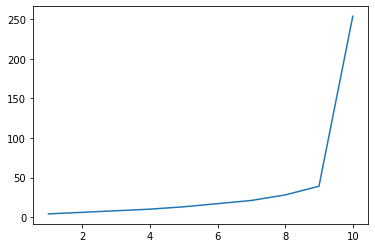

In [ ]:
length_sequence_section=[]
for i in range(1,11):
  idx=(len(length)-1)*i//10
  length_sequence_section.append(length[idx])
plt.plot([i for i in range(1,11)],length_sequence_section)


In [ ]:
max_length=50

In [ ]:
padded_sequence=tf.keras.preprocessing.sequence.pad_sequences(sequences,maxlen=max_length,padding="pre",truncating="pre")
labels=np.array(labels)


In [ ]:
training_seq=padded_sequence[:int(len(padded_sequence)*.85)]
test_seq=padded_sequence[int(len(padded_sequence)*.85):]
training_label=labels_shuffled[:int(len(padded_sequence)*.85)]
test_label=labels_shuffled[int(len(padded_sequence)*.85):]

# Callbacks For tuning hyperparameters and early stopping

In [ ]:
class StopCallBack(tf.keras.callbacks.Callback):

  def __init__(self,validation,training):
    self.validation=validation
    self.training=training

  def on_epoch_end(self,epochs,logs={}):
    if logs.get("accuracy")>=self.training and logs.get("val_accuracy")>=self.validation:
      self.model.stop_training=True

learning_scheduler_calback=tf.keras.callbacks.LearningRateScheduler(lambda epochs: 1e-8 * 10**(epochs/20))

# Model Creation

In [ ]:
def creat_model():
  embedding_dims=16
  vocab_size=len(word_dict)+1
  model=tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dims,input_shape=(max_length,)),
  tf.keras.layers.Dropout(.6),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
  # tf.keras.layers.Dropout(.5),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(32,activation="relu"),
  tf.keras.layers.Dropout(.6),
  tf.keras.layers.Dense(16,activation="relu"),
  tf.keras.layers.Dropout(.6),
  tf.keras.layers.Dense(1,activation="sigmoid")])
  return model

In [ ]:
print(sum(labels))
print(sum(training_label))
print(sum(test_label))

15198
13573
1625


In [ ]:
training_label=np.array(training_label)
test_label=np.array(test_label)

In [ ]:
model=creat_model()
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 50, 16)            1806208   
                                                                 
 dropout_22 (Dropout)        (None, 50, 16)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_20 (Dense)            (None, 32)                2080      
                                                                 
 dropout_23 (Dropout)        (None, 32)                0         
                                                                 
 dense_21 (Dense)            (None, 16)                528       
                                                     

In [ ]:
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [ ]:
history=model.fit(training_seq,training_label,epochs=50,batch_size=512,validation_data=(test_seq,test_label))

Epoch 1/50
50/50 [==============================] - 5s 36ms/step - loss: 0.6923 - accuracy: 0.5236 - val_loss: 0.7036 - val_accuracy: 0.3611
Epoch 2/50
50/50 [==============================] - 1s 12ms/step - loss: 0.6915 - accuracy: 0.5323 - val_loss: 0.7065 - val_accuracy: 0.3611
Epoch 3/50
50/50 [==============================] - 1s 11ms/step - loss: 0.6879 - accuracy: 0.5344 - val_loss: 0.7051 - val_accuracy: 0.3611
Epoch 4/50
50/50 [==============================] - 1s 11ms/step - loss: 0.6496 - accuracy: 0.6127 - val_loss: 0.5868 - val_accuracy: 0.7702
Epoch 5/50
50/50 [==============================] - 1s 11ms/step - loss: 0.5519 - accuracy: 0.7398 - val_loss: 0.4789 - val_accuracy: 0.7882
Epoch 6/50
50/50 [==============================] - 1s 11ms/step - loss: 0.4422 - accuracy: 0.8177 - val_loss: 0.4121 - val_accuracy: 0.8244
Epoch 7/50
50/50 [==============================] - 1s 11ms/step - loss: 0.3467 - accuracy: 0.8676 - val_loss: 0.4091 - val_accuracy: 0.8384
Epoch 8/50
50

In [ ]:
val_accuracy=history.history["val_accuracy"]
accuracy=history.history["accuracy"]
loss=history.history["loss"]

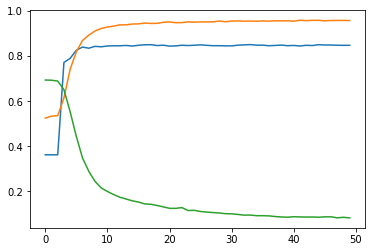

In [ ]:
plt.plot(val_accuracy)
plt.plot(accuracy)
plt.plot(loss)

In [ ]:
model_one_lstm=tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_dict)+1,10,input_length=50),
    tf.keras.layers.LSTM(2),
    tf.keras.layers.Dropout(.6),
    tf.keras.layers.Dense(1,activation="sigmoid")
])

In [ ]:
model_one_lstm.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 50, 10)            1128880   
                                                                 
 lstm_12 (LSTM)              (None, 2)                 104       
                                                                 
 dropout_17 (Dropout)        (None, 2)                 0         
                                                                 
 dense_14 (Dense)            (None, 1)                 3         
                                                                 
Total params: 1,128,987
Trainable params: 1,128,987
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=0.001)
model_one_lstm.compile(loss="binary_crossentropy",metrics=["accuracy"],optimizer="adam")

In [ ]:
history=model_one_lstm.fit(training_seq,training_label,epochs=100,batch_size=128,validation_data=(test_seq,test_label))


Epoch 1/100
200/200 [==============================] - 3s 9ms/step - loss: 0.6901 - accuracy: 0.5356 - val_loss: 0.6951 - val_accuracy: 0.4451
Epoch 2/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6542 - accuracy: 0.6134 - val_loss: 0.5884 - val_accuracy: 0.7640
Epoch 3/100
200/200 [==============================] - 1s 6ms/step - loss: 0.5683 - accuracy: 0.6926 - val_loss: 0.5066 - val_accuracy: 0.8016
Epoch 4/100
200/200 [==============================] - 1s 7ms/step - loss: 0.4892 - accuracy: 0.7401 - val_loss: 0.4547 - val_accuracy: 0.8251
Epoch 5/100
200/200 [==============================] - 1s 7ms/step - loss: 0.4331 - accuracy: 0.7682 - val_loss: 0.4110 - val_accuracy: 0.8342
Epoch 6/100
200/200 [==============================] - 1s 7ms/step - loss: 0.4012 - accuracy: 0.7810 - val_loss: 0.3936 - val_accuracy: 0.8404
Epoch 7/100
200/200 [==============================] - 1s 7ms/step - loss: 0.3772 - accuracy: 0.7909 - val_loss: 0.3821 - val_accuracy: 0.8436

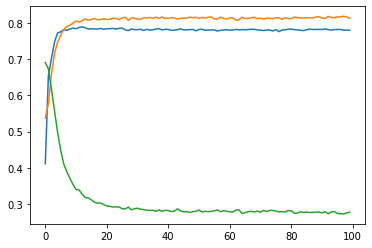

In [ ]:
val_accuracy=history.history["val_accuracy"]
accuracy=history.history["accuracy"]
loss=history.history["loss"]
plt.plot(val_accuracy)
plt.plot(accuracy)
plt.plot(loss)

In [ ]:
def create_model_with_conv1D(vocab_size=100,embedding_dims=100,max_len=100):
  inputs=tf.keras.layers.Input(shape=(50,))
  x=tf.keras.layers.Embedding(len(word_dict)+1,100,input_length=max_len)(inputs)
  x=tf.keras.layers.Conv1D(32,4,activation="relu")(x)
  x=tf.keras.layers.GlobalAveragePooling1D()(x)
  x=tf.keras.layers.Dropout(.5)(x)

  # deleted the layers below because the dimensions didn't match
  # we can use lambda layer to expand the dims so that it matches the expected dims

  # x=tf.keras.layers.Conv1D(128,4,activation="relu")(x)
  # x=tf.keras.layers.GlobalAveragePooling1D()(x)
  # x=tf.keras.layers.Dropout(.5)(x)

  x=tf.keras.layers.Dense(16,activation="relu")(x)
  x=tf.keras.layers.Dropout(.3)(x)
  x=tf.keras.layers.Dense(8,activation="relu")(x)
  outputs=tf.keras.layers.Dense(1,activation="sigmoid")(x)
  model=tf.keras.Model(inputs=inputs,outputs=outputs)
  return model

In [ ]:
model_2=create_model_with_conv1D()
model_2.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_13 (Embedding)    (None, 50, 100)           11288800  
                                                                 
 conv1d (Conv1D)             (None, 47, 32)            12832     
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_18 (Dropout)        (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 16)                528       
                                                             

In [ ]:
model_2.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
history=model_2.fit(training_seq,training_label,epochs=50,batch_size=512,validation_data=(test_seq,test_label))

Epoch 1/50
50/50 [==============================] - 6s 19ms/step - loss: 0.6916 - accuracy: 0.5316 - val_loss: 0.7070 - val_accuracy: 0.3611
Epoch 2/50
50/50 [==============================] - 1s 11ms/step - loss: 0.6807 - accuracy: 0.5384 - val_loss: 0.6759 - val_accuracy: 0.6191
Epoch 3/50
50/50 [==============================] - 1s 12ms/step - loss: 0.5887 - accuracy: 0.7161 - val_loss: 0.5116 - val_accuracy: 0.8087
Epoch 4/50
50/50 [==============================] - 1s 13ms/step - loss: 0.3882 - accuracy: 0.8528 - val_loss: 0.4313 - val_accuracy: 0.8402
Epoch 5/50
50/50 [==============================] - 1s 12ms/step - loss: 0.2616 - accuracy: 0.9098 - val_loss: 0.4412 - val_accuracy: 0.8498
Epoch 6/50
50/50 [==============================] - 1s 12ms/step - loss: 0.2093 - accuracy: 0.9321 - val_loss: 0.4619 - val_accuracy: 0.8520
Epoch 7/50
50/50 [==============================] - 1s 12ms/step - loss: 0.1787 - accuracy: 0.9418 - val_loss: 0.4825 - val_accuracy: 0.8540
Epoch 8/50
50

In [ ]:
model_2.save("model_3.h5")

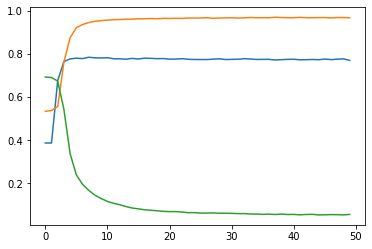

In [ ]:
val_accuracy=history.history["val_accuracy"]
accuracy=history.history["accuracy"]
loss=history.history["loss"]
plt.plot(val_accuracy)
plt.plot(accuracy)
plt.plot(loss)

In [ ]:
def creat_model_no_rnn():
  embedding_dims=16
  vocab_size=len(word_dict)+1
  inputs=tf.keras.layers.Input(shape=(50))
  x=tf.keras.layers.Embedding(vocab_size,embedding_dims,input_length=100)(inputs) #returns word embedding matrix for the input
  # insted of flatten averages over the columns
  x=tf.keras.layers.Dropout(.5)(x)
  x=tf.keras.layers.GlobalAveragePooling1D()(x)
  x= tf.keras.layers.Dense(24, activation='relu',kernel_regularizer=tf.keras.regularizers.l2())(x)
  x=tf.keras.layers.Dropout(.5)(x)
  outputs=tf.keras.layers.Dense(1, activation='sigmoid')(x)
  model=tf.keras.Model(inputs=inputs,outputs=outputs)
  return model

In [ ]:
model_3=creat_model_no_rnn()
model_3.summary()
model_3.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_14 (Embedding)    (None, 50, 16)            1806208   
                                                                 
 dropout_20 (Dropout)        (None, 50, 16)            0         
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_18 (Dense)            (None, 24)                408       
                                                                 
 dropout_21 (Dropout)        (None, 24)                0         
                                                           

Epoch 1/50
50/50 [==============================] - 1s 12ms/step - loss: 0.8589 - accuracy: 0.5276 - val_loss: 0.8443 - val_accuracy: 0.3611
Epoch 2/50
50/50 [==============================] - 0s 8ms/step - loss: 0.8021 - accuracy: 0.5323 - val_loss: 0.7995 - val_accuracy: 0.3611
Epoch 3/50
50/50 [==============================] - 0s 9ms/step - loss: 0.7634 - accuracy: 0.5323 - val_loss: 0.7705 - val_accuracy: 0.3611
Epoch 4/50
50/50 [==============================] - 1s 10ms/step - loss: 0.7369 - accuracy: 0.5323 - val_loss: 0.7490 - val_accuracy: 0.3611
Epoch 5/50
50/50 [==============================] - 0s 9ms/step - loss: 0.7192 - accuracy: 0.5323 - val_loss: 0.7349 - val_accuracy: 0.3611
Epoch 6/50
50/50 [==============================] - 1s 14ms/step - loss: 0.7075 - accuracy: 0.5323 - val_loss: 0.7192 - val_accuracy: 0.3611
Epoch 7/50
50/50 [==============================] - 1s 12ms/step - loss: 0.6997 - accuracy: 0.5340 - val_loss: 0.7188 - val_accuracy: 0.3611
Epoch 8/50
50/50

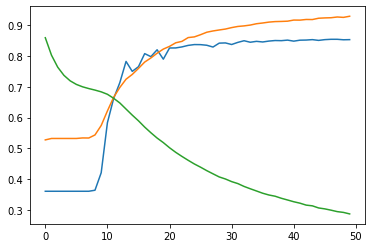

In [ ]:
history=model_3.fit(training_seq,training_label,epochs=50,batch_size=512,validation_data=(test_seq,test_label))
val_accuracy=history.history["val_accuracy"]
accuracy=history.history["accuracy"]
loss=history.history["loss"]
plt.plot(val_accuracy)
plt.plot(accuracy)
plt.plot(loss)

In [ ]:
model_3.save("model_4.h5")

In [ ]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_dict)+1, 15, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10)),
    tf.keras.layers.Dropout(.6),
    tf.keras.layers.Dense(8, activation='relu',kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [ ]:
model_lstm.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 50, 15)            1693320   
                                                                 
 bidirectional_6 (Bidirectio  (None, 20)               2080      
 nal)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 20)                0         
                                                                 
 dense_29 (Dense)            (None, 8)                 168       
                                                                 
 dropout_31 (Dropout)        (None, 8)                 0         
                                                                 
 dense_30 (Dense)            (None, 1)                 9         
                                                     

Epoch 1/50
50/50 [==============================] - 4s 26ms/step - loss: 0.7889 - accuracy: 0.5289 - val_loss: 0.7886 - val_accuracy: 0.3611
Epoch 2/50
50/50 [==============================] - 1s 11ms/step - loss: 0.7589 - accuracy: 0.5315 - val_loss: 0.7575 - val_accuracy: 0.3633
Epoch 3/50
50/50 [==============================] - 1s 11ms/step - loss: 0.7275 - accuracy: 0.5898 - val_loss: 0.6623 - val_accuracy: 0.7111
Epoch 4/50
50/50 [==============================] - 1s 11ms/step - loss: 0.6471 - accuracy: 0.7053 - val_loss: 0.5577 - val_accuracy: 0.7947
Epoch 5/50
50/50 [==============================] - 1s 11ms/step - loss: 0.5215 - accuracy: 0.8015 - val_loss: 0.4710 - val_accuracy: 0.8253
Epoch 6/50
50/50 [==============================] - 1s 11ms/step - loss: 0.4184 - accuracy: 0.8581 - val_loss: 0.4545 - val_accuracy: 0.8371
Epoch 7/50
50/50 [==============================] - 1s 11ms/step - loss: 0.3523 - accuracy: 0.8930 - val_loss: 0.4578 - val_accuracy: 0.8416
Epoch 8/50
50

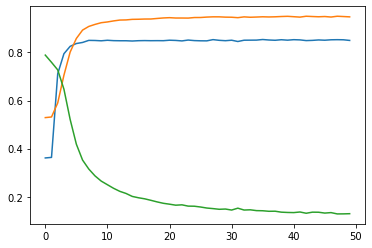

In [ ]:
history=model_lstm.fit(training_seq,training_label,epochs=50,batch_size=512,validation_data=(test_seq,test_label))
val_accuracy=history.history["val_accuracy"]
accuracy=history.history["accuracy"]
loss=history.history["loss"]
plt.plot(val_accuracy)
plt.plot(accuracy)
plt.plot(loss)

In [ ]:
model_lstm.save("")